## Prueba Científico de Datos - Aflore

### Contexto

**Instrucciones Aflore**

Aplicar al conjunto de datos proporcionado el clasificador de Naive Bayes. Los datos se proporcionan en formato csv.

Descripción de la actividad
- Análisis descriptivo de los datos.
- Determinar el conjunto de modelización y el de validación.
- Tratamiento de missing.
- Calcular las métricas de evaluación de ajuste adecuadas.
- Comentar los resultados obtenidos.
- Otros comentarios que parezcan adecuados.
- Platear como lo haría en MySql o Postgresql (resolverlo en sql es plus)


https://archive.ics.uci.edu/ml/datasets/congressional+voting+records contiene la información necesaria sobre los datos, la variable respuesta es «Class name»

Los datos tratan información relacionada con el voto en las elecciones americanas.
- Máximo de 3 páginas
- Usar Python
- Se deben comentar los resultados obtenidos y el código en jupyter


**Contexto [fuente de datos](https://archive.ics.uci.edu/ml/datasets/congressional+voting+records)**

In [19]:
# Ver contexto de los datos
!cat ../datos/house-votes-84.names

1. Title: 1984 United States Congressional Voting Records Database

2. Source Information:
    (a) Source:  Congressional Quarterly Almanac, 98th Congress, 
                 2nd session 1984, Volume XL: Congressional Quarterly Inc. 
                 Washington, D.C., 1985.
    (b) Donor: Jeff Schlimmer (Jeffrey.Schlimmer@a.gp.cs.cmu.edu)
    (c) Date: 27 April 1987 

3. Past Usage
   - Publications
     1. Schlimmer, J. C. (1987).  Concept acquisition through 
        representational adjustment.  Doctoral dissertation, Department of 
        Information and Computer Science, University of California, Irvine, CA.
        -- Results: about 90%-95% accuracy appears to be STAGGER's asymptote
     - Predicted attribute: party affiliation (2 classes)

4. Relevant Information:
      This data set includes votes for each of the U.S. House of
      Representatives Congressmen on the 16 key votes identified by the
      CQA.  The CQA lists nine different types of votes: voted for, paired
      

### Importar módulos y datos

In [17]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import CategoricalNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, roc_curve, auc, roc_auc_score, \
                            RocCurveDisplay, confusion_matrix, ConfusionMatrixDisplay
from sklearn.calibration import calibration_curve, CalibratedClassifierCV

In [20]:
%%bash
# Visualizar primeras filas para entender estructura de los datos
head -n 5 ../datos/house-votes-84.data

republican,n,y,n,y,y,y,n,n,n,y,?,y,y,y,n,y
republican,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,?
democrat,?,y,y,?,y,y,n,n,n,n,y,n,y,y,n,n
democrat,n,y,y,n,?,y,n,n,n,n,y,n,y,n,n,y
democrat,y,y,y,n,y,y,n,n,n,n,y,?,y,y,y,y


In [21]:
# Importar datos con columnas nombradas correctamente
columns = ['party', 'handicapped_infants', 'water_project', 'budget_resolution', 'physicial_fee_freeze', 'el_salvador_aid', 
           'religious_groups_schools', 'anti_satellite_test_ban', 'aid_contras', 'mx_missile', 'immigration',
           'synfuels_cutback', 'education_spending', 'superfund_right_to_sue', 'crime', 'duty_free_exports', 
           'export_admin_act_south_africa']
data = pd.read_csv("../datos/house-votes-84.data", names=columns)

# Visualizar datos
data.head()

,party,handicapped_infants,water_project,budget_resolution,physicial_fee_freeze,el_salvador_aid,religious_groups_schools,anti_satellite_test_ban,aid_contras,mx_missile,immigration,synfuels_cutback,education_spending,superfund_right_to_sue,crime,duty_free_exports,export_admin_act_south_africa
0,republican,n,y,n,y,y,y,n,n,n,y,?,y,y,y,n,y
1,republican,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,?
2,democrat,?,y,y,?,y,y,n,n,n,n,y,n,y,y,n,n
3,democrat,n,y,y,n,?,y,n,n,n,n,y,n,y,n,n,y
4,democrat,y,y,y,n,y,y,n,n,n,n,y,?,y,y,y,y


### Análisis exploratorio y limpieza de los datos

#### Estructura de los datos

In [6]:
print(f"""
Columnas: \t{data.shape[1]:,d}
Filas: \t\t{data.shape[0]:,d}

Columnas y tipos:
{data.dtypes}
""")


Columnas: 	17
Filas: 		435

Columnas y tipos:
party                            object
handicapped_infants              object
water_project                    object
budget_resolution                object
physicial_fee_freeze             object
el_salvador_aid                  object
religious_groups_schools         object
anti_satellite_test_ban          object
aid_contras                      object
mx_missile                       object
immigration                      object
synfuels_cutback                 object
education_spending               object
superfund_right_to_sue           object
crime                            object
duty_free_exports                object
export_admin_act_south_africa    object
dtype: object



#### Datos en blanco

In [7]:
# Datos en blanco?
missing = data.isna().sum().sum()
print(f"Datos en blanco: {missing:,d}")

Datos en blanco: 0


Debería haber datos en blanco, de acuerdo a la documentación. Como se ve en el siguiente bloque. Esto se debe a que la documentación se refiere a los '`?`' como datos en blanco.

Sin embargo, como también explica la documentación, no es correcto que los valores `'?'` se refieran a valores desconocidos, sino a votos que no son a favor ni en contra (votos neutros). Es decir, estos no son datos faltantes o en blanco, son un valor definido, y deben tratarse como tal.

Adicional a esto, hay una discrepancia entre el conteo de votos neutros incluido en la documentación y el obtenido en el siguiente bloque. De acuerdo a los resultados observados, pareciese que la documentación trocara los valores de cada columna una posición hacia abajo. Para tener más certeza de que esto es un error en la documentación, conté los valores utilizando Bash (dos bloques más abajo) en vez de Python, donde obtuve los mismos resultados. Por lo tanto, asumiré que esto es un error en la documentación, no en los datos.

In [8]:
for idx, col in enumerate(columns):
    print(f"{idx + 1:2}. {col} \t{(data[col] == '?').sum()}")

 1. party 	0
 2. handicapped_infants 	12
 3. water_project 	48
 4. budget_resolution 	11
 5. physicial_fee_freeze 	11
 6. el_salvador_aid 	15
 7. religious_groups_schools 	11
 8. anti_satellite_test_ban 	14
 9. aid_contras 	15
10. mx_missile 	22
11. immigration 	7
12. synfuels_cutback 	21
13. education_spending 	31
14. superfund_right_to_sue 	25
15. crime 	17
16. duty_free_exports 	28
17. export_admin_act_south_africa 	104


In [9]:
%%bash
# Validar si obtengo el mismo conteo de '?' en Bash
cut -f2 -d, ../data/house-votes-84.data | sort | uniq -c

     12 ?
    236 n
    187 y


En conclusuión, estos datos no contienen valores en blanco (missing), por lo que no es necesario tratarlos (por ejemplo, imputarlos)

#### Análisis univariado

Partido

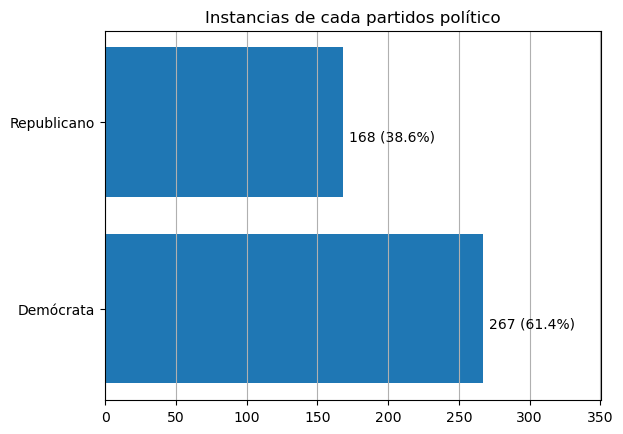

In [11]:
# Graficar conteo de instancias en cada partido
party_count = data['party'].value_counts()
fig, ax = plt.subplots()
ax.barh(y=party_count.index, width=party_count)
ax.set_title("Instancias de cada partidos político")
ax.grid(axis='x')
ax.set_yticks(['republican', 'democrat'])
ax.set_yticklabels(['Republicano', 'Demócrata'])

ax.set_xlim(xmax=ax.get_xlim()[1] * 1.25)

for idx, party in enumerate(party_count.index):
    counter = party_count.loc[party, ]
    ax.text(y=idx - 0.1, 
            x=party_count.loc[party, ] + 4, 
            s=f"{counter} ({counter / data.shape[0] * 100:.1f}%)")
plt.show()

Votaciones

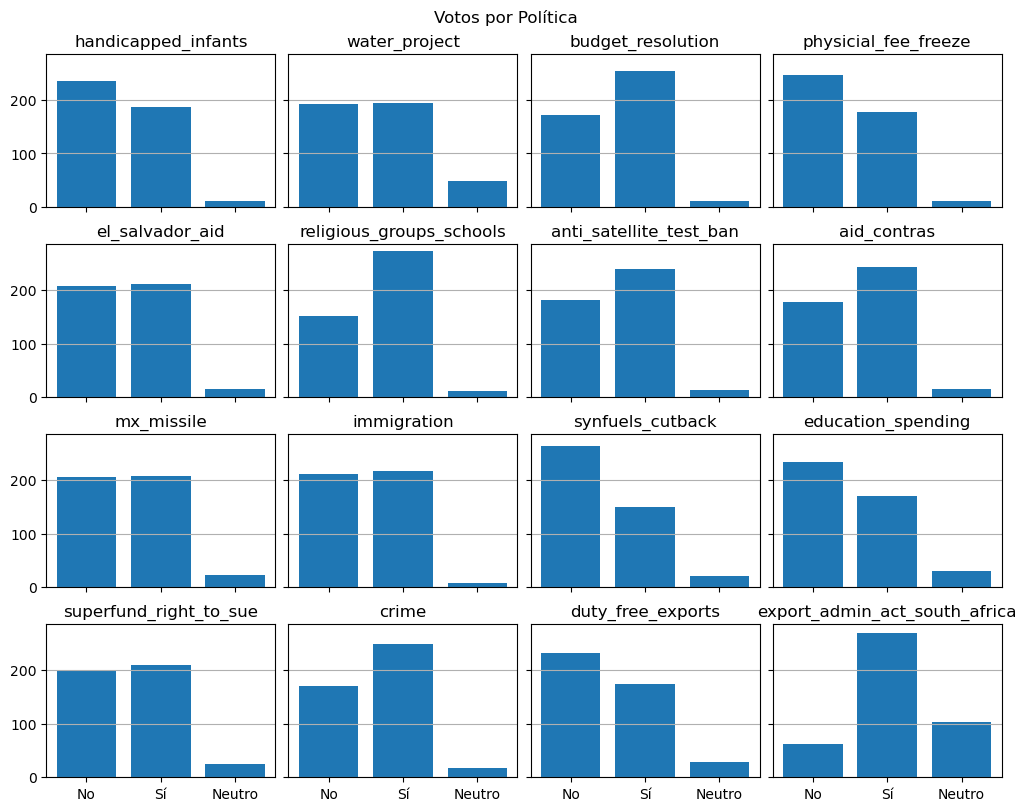

In [15]:
# Calcular dimensiones de matriz de gráficos
plots_num = len(data.columns) - 1
rows_cols_num = int(np.sqrt(plots_num) // 1)

# Crea figura que contendrá los gráficos
fig, axs = plt.subplots(ncols=rows_cols_num, 
                        nrows=rows_cols_num, 
                        figsize=(10, 8), 
                        sharex=True, 
                        sharey=True, 
                        layout='constrained')
fig.suptitle("Votos por Política")

# Graficar proporción de votos de cada una de las votaciones
for idx, col in enumerate(columns[1:]):
        voting_count = data[col].value_counts()
        curr_row = idx // rows_cols_num
        curr_col = idx % rows_cols_num
        curr_ax = axs[curr_row][curr_col]
        curr_ax.bar(x=voting_count.index, height=voting_count)
        curr_ax.grid(axis='y')
        curr_ax.set_title(col)
        curr_ax.set_xticks(['n', 'y', '?'])
        curr_ax.set_xticklabels(['No', 'Sí', 'Neutro']);

#### Análisis bivariado

Para el análisis vibariado, me concentraré en encontrar políticas que me permitan predecir el partido de un representante en función de cómo haya votado en cada una de las 16 votaciones contenidas en el conjunto de datos.

En este caso, estamos tratando con variables nominales (partido vs votación X) donde una de las variables tiene más de dos valores (No, Sí, Neutro), por lo que puedo utilizar el coeficiente de Cramer para calcular la correlación entre el partido y cada una de las votaciones.

In [3]:
# Codificar todas las variables por valores numéricos
codes_to_replace = {'republican': 1,
                    'democrat': 0, 
                    'n': 0, 
                    'y': 1, 
                    '?': 2}

data_encoded = data.replace(codes_to_replace)

# Definir función para calcular V de Cramer
def v_cramer(var1, var2):
    """ Calculates Cramer's V for two nominal variables
    
    Keyword arguments:
    var1 - First nominal variables
    var2 - Second nominal variable
    """
    crosstab =np.array(pd.crosstab(var1,var2, rownames=None, colnames=None))
    stat = stats.chi2_contingency(crosstab)[0] 
    obs = np.sum(crosstab)
    mini = min(crosstab.shape) - 1
    
    return (stat/(obs*mini))

# Calcular V de Cramer entre Partido y cada una de la variables de votación
v_cramers = []
for x_train_col in data.columns[1:]:
    cramer = v_cramer(data_encoded['party'], data_encoded[x_train_col])
    v_cramers.append(np.round(cramer, 2))

# Imprimir resultados, de mayor a menor valor
v_cramers = pd.Series(v_cramers, index=data.columns[1:])
print('V de Cramer (Partido vs Votación X):')
v_cramers.sort_values(ascending=False)

V de Cramer (Partido vs Votación X):


physicial_fee_freeze             0.83
budget_resolution                0.55
el_salvador_aid                  0.51
education_spending               0.47
aid_contras                      0.44
mx_missile                       0.40
crime                            0.38
superfund_right_to_sue           0.29
duty_free_exports                0.27
anti_satellite_test_ban          0.26
religious_groups_schools         0.18
handicapped_infants              0.17
synfuels_cutback                 0.14
export_admin_act_south_africa    0.14
immigration                      0.01
water_project                    0.00
dtype: float64

### Modelación

#### Contexto del Problema

El modelo creado intentará resolver la siguiente pregunta hipotética: 

#### Preparacion de los datos

Codificar todas las variables

In [4]:
# Codificar todas las variables por valores numéricos
codes_to_replace = {'republican': 1,
                    'democrat': 0, 
                    'n': 0, 
                    'y': 1, 
                    '?': 2}

data_encoded = data.replace(codes_to_replace)

A pesar de que la variable independiente no es completamente balanceada, el desbalance está dentro de un rango razonable. Igualmente, más adelante validaré si el desbalance observado tiene algún impacto sobre el deesempeño del modelo, mediante el uso de métricas de desempeño que tengan en cuenta este desbalance.

In [5]:
data_encoded['party'].value_counts() / data_encoded.shape[0] * 100

0    61.37931
1    38.62069
Name: party, dtype: float64

Dividir en conjunto de datos de entrenamiento y validación

In [6]:
# Dividir datos en conjunto de entrenamiento y validacion
X_train, X_test, y_train, y_test = train_test_split(data_encoded.iloc[:,1:],
                                                    data_encoded.iloc[:, 0],
                                                    test_size=0.2, 
                                                    random_state=67)

print(f"""
Observaciones entrenamiento: \t{X_train.shape[0]:,d}
Observaciones validación: \t{X_test.shape[0]:,d}
""")


Observaciones entrenamiento: 	348
Observaciones validación: 	87



#### Entrenamiento de modelo

Entrenar modelo utilizando `GridSearchCV` para encontrar mejor combinación de hiperparámetros

In [7]:
# Definir modelo y construir parrilla de evaluación de hiperparámetros
classifier = CategoricalNB()
grid = {'alpha': np.arange(0.1, 1.05, 0.1), 
        'fit_prior': [True, False]}
grid_search_clf = GridSearchCV(classifier, 
                               param_grid=grid, 
                               scoring='accuracy', 
                               cv=5)

# Encontrar mejor modelo evaluando hiperparámetros de la parrilla
grid_search_clf.fit(X_train, y_train)

# Seleccionar mejor modelo
best_clf = grid_search_clf.best_estimator_

#### Evaluación de modelo

Evaluar mejor modelo contra conjunto de datos de validación

In [8]:
# Pronostico basado en conjunto de validación
y_test_predict = best_clf.predict(X_test)

# Probabilidades pronosticadas
y_test_prob = best_clf.predict_proba(X_test, )
y_test_prob = [row[1] for row in y_test_prob]

Matriz de confusión

Text(0.5, 1.0, 'Matriz de Confusión')

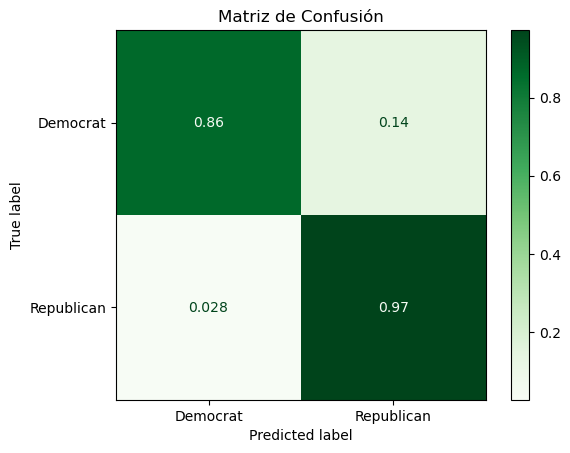

In [9]:
confusion = confusion_matrix(y_test, 
                             y_test_predict, 
                             normalize='true')
confusion_disp = ConfusionMatrixDisplay(confusion, 
                                        display_labels=['Democrat', 'Republican']) 
confusion_disp.plot(cmap='Greens')
confusion_disp.ax_.set_title('Matriz de Confusión')

Métricas de desempeño

In [10]:
# Calcular métricas de desempeño
accuracy = accuracy_score(y_test, y_test_predict)
balanced_accuracy = balanced_accuracy_score(y_test, y_test_predict)
f1 = f1_score(y_test, y_test_predict)

print(f"""
Accuracy: \t\t{accuracy:.2f}
Accuracy (balanceada): \t{balanced_accuracy:.2f}
F1: \t\t\t{f1:.2f}
""")



Accuracy: 		0.91
Accuracy (balanceada): 	0.92
F1: 			0.90



Curva ROC

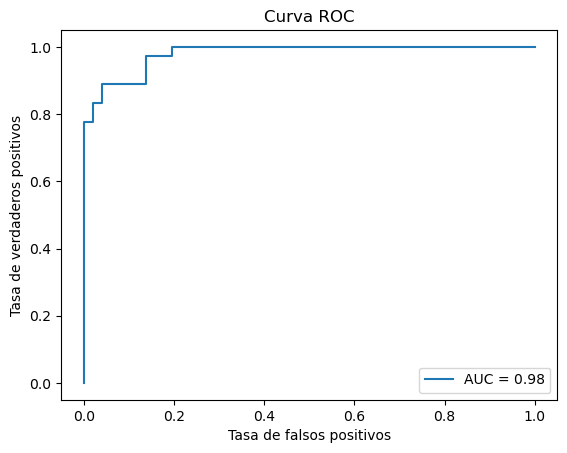

In [16]:
area_under_roc = roc_auc_score(y_test, y_test_prob)
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)
roc_auc = auc(fpr, tpr)
roc_curve_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
roc_curve_display.plot()
roc_curve_display.ax_.set_title("Curva ROC")
roc_curve_display.ax_.set_xlabel("Tasa de falsos positivos")
roc_curve_display.ax_.set_ylabel("Tasa de verdaderos positivos")
plt.show()

Evaluar calibración

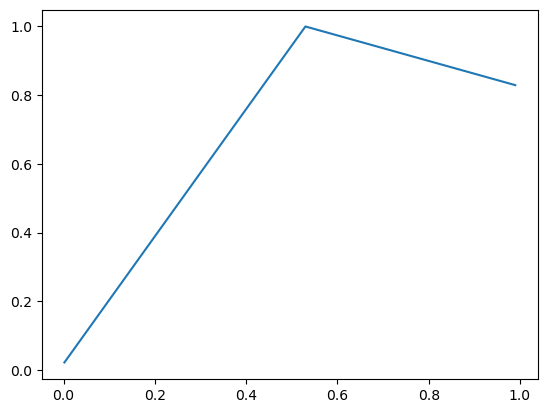

In [113]:
calibration = calibration_curve(y_test, y_test_prob, n_bins=4)
plt.plot(calibration[1], calibration[0])

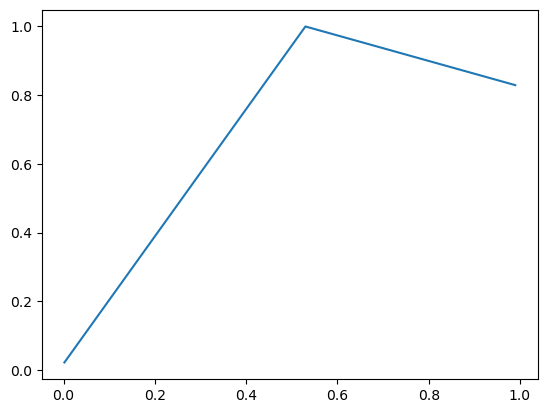

In [115]:
calibrated_clf = CalibratedClassifierCV(best_clf)
calibrated_clf.fit(X_train, y_train)

y_test_prob_calib = calibrated_clf.predict_proba(X_test)
y_test_prob_calib = [row[1] for row in y_test_prob_calib]

calibration_calibrated = calibration_curve(y_test, y_test_prob_calib, n_bins=4)
plt.plot(calibration[1], calibration[0])

Exportar modelo

In [18]:
model_name = '../modelos/naive_bayes_classifier.pkl'
joblib.dump(best_clf, model_name, compress=9)

['../models/naive_bayes_classifier.pkl']